<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/Week%207/Assignment/DeepRNN/Review_Toko_Baju_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import keras_tuner as kt

## Data Preparation

In [5]:
# Load dataset
url = "https://raw.githubusercontent.com/farrelrassya/teachingMLDL/refs/heads/main/02.%20Deep%20Learning/04.%20Week%204/Dataset/ReviewTokoBaju.csv"
df = pd.read_csv(url)

df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [7]:
df.isna().sum()

,0
Unnamed: 0,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
print(df.columns)

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')


In [10]:
df.dropna(inplace=True)

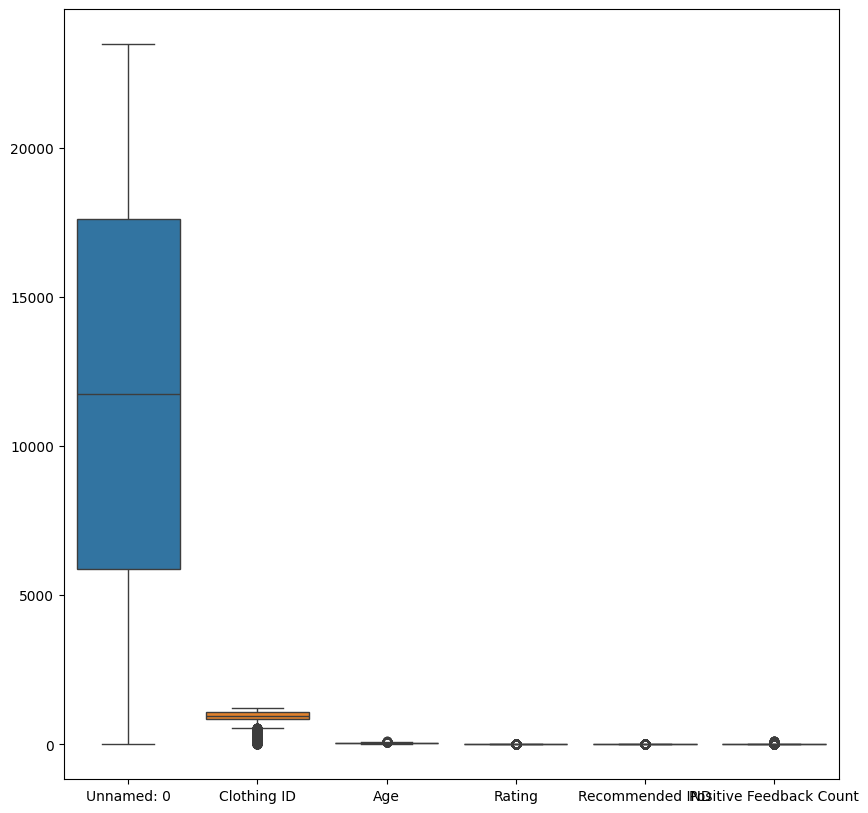

In [11]:
plt.figure(figsize=(10, 10))
sns.boxplot(data=df)
plt.show()

## Pre-Processing Data

In [12]:
df = df[['Review Text', 'Rating']].copy()
df.dropna(inplace=True)

def get_sentiment(rating):
    if rating >= 4:
        return 1
    elif rating <= 2:
        return 0
    else:
        return None

df.loc[:, 'Label'] = df['Rating'].apply(get_sentiment)
df.dropna(inplace=True)
df.loc[:, 'Label'] = df['Label'].astype(int)

In [13]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text

df['Review Text'] = df['Review Text'].apply(clean_text)
df = df[df['Review Text'].str.strip() != '']

In [14]:
X = df['Review Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
tokenizer = Tokenizer(num_words=40000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)
vocab_size = len(tokenizer.word_index) + 1

In [16]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

## RNN Model

###Recurrent Neural Network (RNN)

Pada RNN, hidden state diperbarui menggunakan input saat ini dan hidden state sebelumnya:

$$
h_t = \tanh(W_{hh} h_{t-1} + W_{xh} x_t + b_h)
$$

Output (jika digunakan secara langsung):

$$
y_t = W_{hy} h_t + b_y
$$

In [17]:
# Definisikan model dalam bentuk fungsi yang menerima hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))

    # Tuning unit RNN pertama
    model.add(SimpleRNN(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN kedua
    model.add(SimpleRNN(units=hp.Int('units_2', min_value=32, max_value=128, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.6, step=0.2)))

    # Tuning unit RNN ketiga
    model.add(SimpleRNN(units=hp.Int('units_3', min_value=32, max_value=128, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.2, max_value=0.6, step=0.2)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model dengan learning rate yang dapat dituning
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
                  metrics=['accuracy',
                           tf.keras.metrics.Precision(),
                           tf.keras.metrics.Recall(),
                           tf.keras.metrics.AUC(name='auc')])

    return model

### Hyperparameter Tuning

In [18]:
# Inisialisasi Keras Tuner dengan RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Hanya 5 iterasi
    executions_per_trial=1,  # Hanya satu percobaan untuk setiap kombinasi hyperparameter
    directory='kt_dir',
    project_name='review_sentiment_tuning',
    overwrite=True
)

# Melakukan pencarian hyperparameter
tuner.search(X_train_pad, y_train, epochs=5, batch_size=32, validation_data=(X_test_pad, y_test), class_weight=class_weights)

# Ambil model terbaik dan simpannya
best_model = tuner.get_best_models(num_models=1)[0]
best_model.save('best_model.h5')

# Tampilkan hasil pencarian hyperparameter terbaik
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hyperparameters.values)


Trial 5 Complete [00h 01m 51s]
val_loss: 0.2157038450241089

Best val_loss So Far: 0.2157038450241089
Total elapsed time: 00h 08m 31s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best hyperparameters: {'units_1': 32, 'dropout_1': 0.4, 'units_2': 64, 'dropout_2': 0.4, 'units_3': 96, 'dropout_3': 0.4, 'learning_rate': 7.20463317519233e-05}


### Final Training

In [21]:
# Muat model terbaik yang sudah disimpan
best_model = tf.keras.models.load_model('best_model.h5')

# Kompilasi ulang model setelah dimuat
best_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_hyperparameters['learning_rate']),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(name='auc')]
)

# Melakukan final training (fine-tuning) pada model terbaik
history = best_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    class_weight=class_weights,
    verbose=1
)

Epoch 1/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9169 - auc: 0.9708 - loss: 0.2097 - precision_1: 0.9900 - recall_1: 0.9149 - val_accuracy: 0.8956 - val_auc: 0.9475 - val_loss: 0.2783 - val_precision_1: 0.9764 - val_recall_1: 0.9030
Epoch 2/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 30s 25ms/step - accuracy: 0.9385 - auc: 0.9830 - loss: 0.1569 - precision_1: 0.9941 - recall_1: 0.9355 - val_accuracy: 0.9230 - val_auc: 0.9443 - val_loss: 0.2434 - val_precision_1: 0.9633 - val_recall_1: 0.9483
Epoch 3/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9534 - auc: 0.9880 - loss: 0.1241 - precision_1: 0.9949 - recall_1: 0.9520 - val_accuracy: 0.9076 - val_auc: 0.9403 - val_loss: 0.2912 - val_precision_1: 0.9684 - val_recall_1: 0.9248
Epoch 4/5
430/430 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.9634 - auc: 0.9899 - loss: 0.1020 - precision_1: 0.9961 - recall_1: 0.9623 - val_accuracy: 0.9061 - val_auc: 0.9417 - val_loss: 0.3271 - val_precision_1: 0.9723 - val_recall_1: 0.9

### Evaluasi dan Akurasi

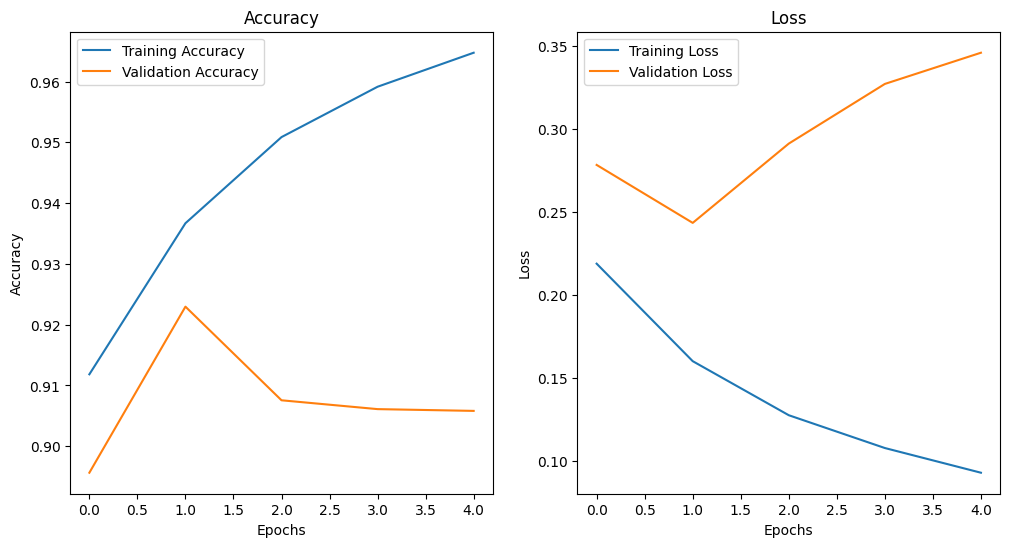

In [22]:
# Plot training & validation accuracy dan loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
# Menggunakan model terbaik untuk melakukan prediksi
y_pred_prob = best_model.predict(X_test_pad).flatten()  # Gunakan best_model yang sudah dilatih
y_pred = (y_pred_prob > 0.5).astype(int)  # Prediksi label (0 atau 1) berdasarkan threshold 0.5

# Menghitung metrik evaluasi
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

# Menampilkan hasil metrik
print(f"Akurasi: {acc:.4f}")
print(f"Presisi: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Akurasi: 0.9058
Presisi: 0.9668
Recall: 0.9245
F1-Score: 0.9452
AUC: 0.9436


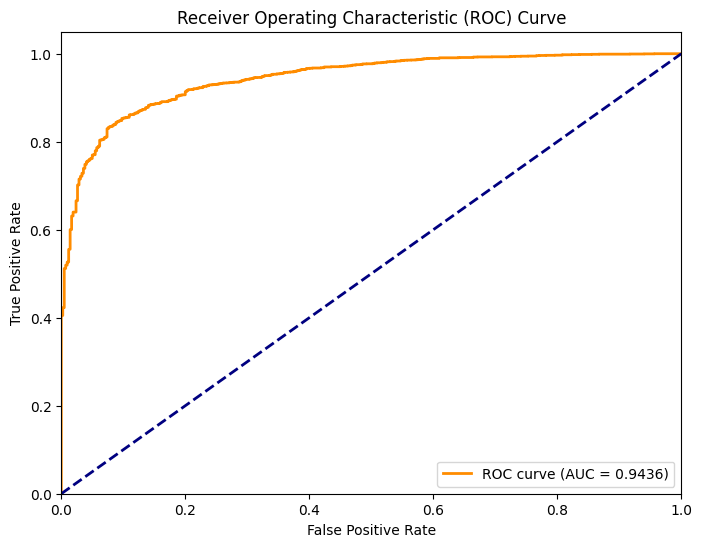

In [25]:
# Import library yang diperlukan
from sklearn.metrics import roc_curve, auc

# Hitung False Positive Rate (FPR), True Positive Rate (TPR), dan Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Hitung AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()